In [10]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import signal
import scipy.io as io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from os import path
from sklearn import metrics, svm, preprocessing, datasets, linear_model
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit, cross_val_score

In [2]:
# generamos un electrodo promedio por cada persona 
# (promediando los 5 electrodos del enunciado que se encuentran juntos)
# y los guardamos en disco. De esta manera a partir de ahora vamos a trabajar solo con esos archivos que son 
# mucho más livianos y tiene toda la información que necesitamos, 894 epochs por cada paciente.

electrodos_a_promediar = [7, 43, 79, 130, 184]

for t in ['P', 'S']:
    for i in range(1,11): 
        try:
            data_file = path.join('./data/',t) + "%02d" % (i) + '.mat'
            elec_prom_file = './dumps/elec_prom_' + t + "%02d" % (i) + '.dmp'
            data = io.loadmat(data_file)['data']
            electrodo_promedio = data[:,electrodos_a_promediar,:].mean(axis=1)
            electrodo_promedio.dump(elec_prom_file)
        except Exception as exception:
            print(str(exception))
            pass

In [3]:
def calculate_welchs(data):
    welchs_by_epoch = np.empty((len(data),2,101))

    for i, epoch in enumerate(data):
        f,p = signal.welch(x=epoch, fs=250)
        welchs_by_epoch[i] = np.array([f,p])
    
    return welchs_by_epoch

In [4]:

welchs = []

for i_type, t in enumerate(['P', 'S']):
    for i in range(1,11):
        try:
            file = './dumps/elec_prom_' + t + "%02d" % (i) + '.dmp'
            print(file)
            data = np.load(file)
            welchs.append(calculate_welchs(data)) 
            #print(data.shape)
            #print(repr(calculate_welchs(data)))
        except Exception as exception:
            print(str(exception))
            pass

./dumps/elec_prom_P01.dmp


/home/amascitti/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


./dumps/elec_prom_P02.dmp
./dumps/elec_prom_P03.dmp
./dumps/elec_prom_P04.dmp
./dumps/elec_prom_P05.dmp
./dumps/elec_prom_P06.dmp
./dumps/elec_prom_P07.dmp
./dumps/elec_prom_P08.dmp
./dumps/elec_prom_P09.dmp
./dumps/elec_prom_P10.dmp
./dumps/elec_prom_S01.dmp
./dumps/elec_prom_S02.dmp
./dumps/elec_prom_S03.dmp
./dumps/elec_prom_S04.dmp
./dumps/elec_prom_S05.dmp
./dumps/elec_prom_S06.dmp
./dumps/elec_prom_S07.dmp
./dumps/elec_prom_S08.dmp
./dumps/elec_prom_S09.dmp
./dumps/elec_prom_S10.dmp


In [5]:
def calculate_epochs_power_mean(welchs_by_epoch, frequency_range):
    freqs = welchs_by_epoch[0,0,:]
    freqs_idxs = np.where((freqs>=frequency_range[0]) * (freqs<frequency_range[1]))
    return welchs_by_epoch[:,1,freqs_idxs].mean(axis=2)



frequencies_ranges = {"delta": (0,4), "theta": (4,8), "alpha": (8,13), "beta": (13,30), "gamma": (30,125)}
# matriz [paciente,banda_freq,epochs,potencia]

potencias_mean_std = np.zeros((20,5,2))
for i in range(20):
    for freq_idx,frequency_range in enumerate(frequencies_ranges.values()):
        frequency_epochs_power_means = calculate_epochs_power_mean(welchs[i],frequency_range)
        potencias_mean_std[i,freq_idx,0] = frequency_epochs_power_means.mean()
        potencias_mean_std[i,freq_idx,1] = frequency_epochs_power_means.std()

        #frequency_power_means.dump(name + 'power_means.dmp')

In [6]:
column_names_mean = list(map(lambda x: x+"_mean",frequencies_ranges.keys()))
df_mean = pd.DataFrame(preprocessing.scale(potencias_mean_std[:,:,0]),columns=column_names_mean)
column_names_std = list(map(lambda x: x+"_std",frequencies_ranges.keys()))
df_std = pd.DataFrame(preprocessing.scale(potencias_mean_std[:,:,1]),columns=column_names_std)

labels = list("P"*10 + "S"*10)
df_labels = pd.DataFrame({"labels":labels})
tabla = pd.concat([df_mean,df_std,df_labels],axis=1)

tabla

,delta_mean,theta_mean,alpha_mean,beta_mean,gamma_mean,delta_std,theta_std,alpha_std,beta_std,gamma_std,labels
0,0.398470,-0.217285,-0.615304,-0.378778,-0.302662,1.354776,0.269945,-0.520973,0.342162,-0.009318,P
1,0.743224,0.608135,-0.697167,-0.790002,-0.251627,0.555005,0.580236,-0.663055,-0.850326,-0.255594,P
2,2.341435,1.216150,-0.529393,-0.719615,-0.537576,2.071140,1.360838,-0.551691,-1.010966,-0.790427,P
3,0.555134,1.280443,-0.416504,-0.691420,-0.595026,0.680326,1.055690,-0.376569,-0.649470,-0.630276,P
4,1.673580,0.771707,-0.514563,-0.201065,0.102021,1.218577,0.361377,-0.563311,-0.611631,-0.097719,P
5,0.902070,0.076607,-0.236513,-0.437895,-0.640285,1.018425,0.152077,-0.239414,-0.084829,-0.801907,P
6,0.970275,0.212998,-0.687344,-0.414019,0.020293,0.834867,0.049960,-0.673183,-0.186525,1.147780,P
7,-0.635269,-0.922474,-0.798451,-1.223363,-0.597616,-0.324027,-0.921870,-0.742939,-1.216570,-0.549190,P
8,0.099139,1.019400,-0.621971,-0.519804,-0.449248,-0.029924,1.047667,-0.585347,-0.418705,-0.662994,P
9,0.987717,-0.004764,-0.656034,-0.589504,-0.408690,1.041334,0.256349,-0.638570,-0.353685,0.219537,P


In [7]:
def graficar_roc(table, values_column_name, labels_column_name,positivo):

    fpr, tpr, thresholds = metrics.roc_curve( \
        table[labels_column_name].values, \
        table[values_column_name].values, \
        pos_label=positivo, drop_intermediate=False)
   
    roc_auc = metrics.auc(fpr, tpr)
   
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {0}'.format(values_column_name))
    plt.legend(loc="lower right")
    plt.show()


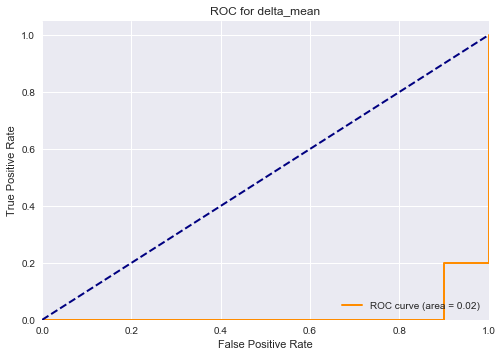

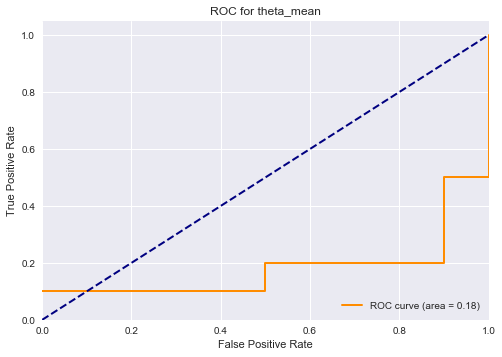

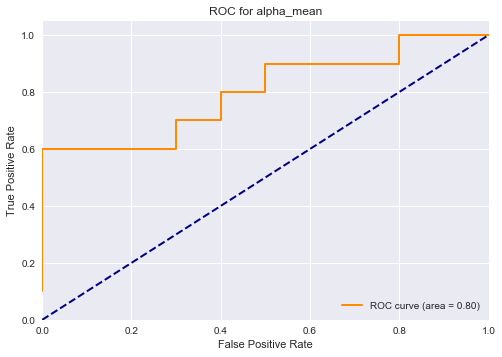

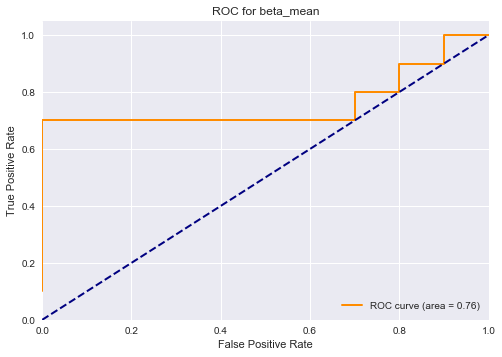

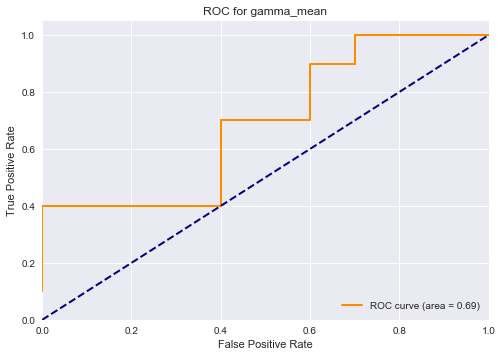

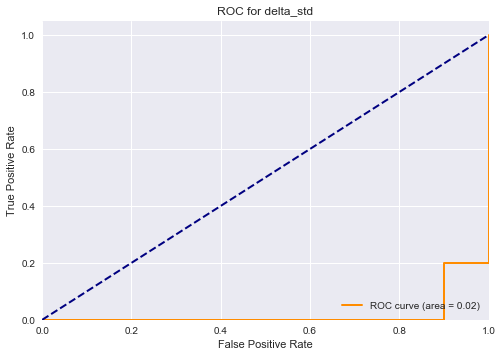

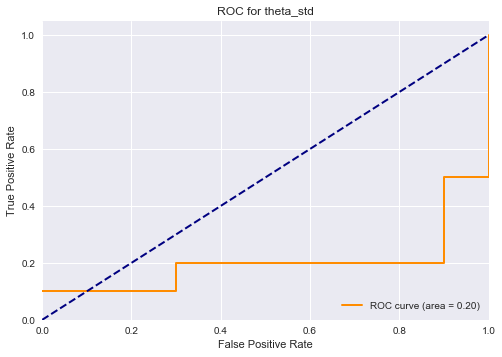

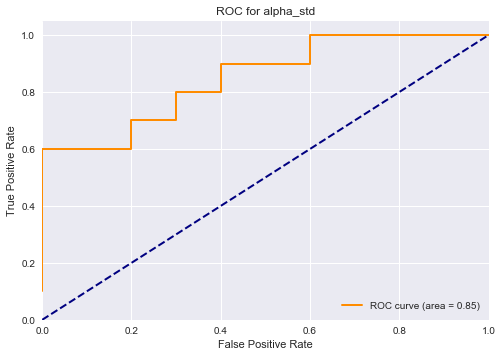

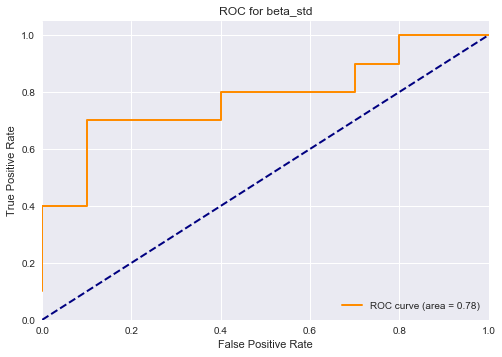

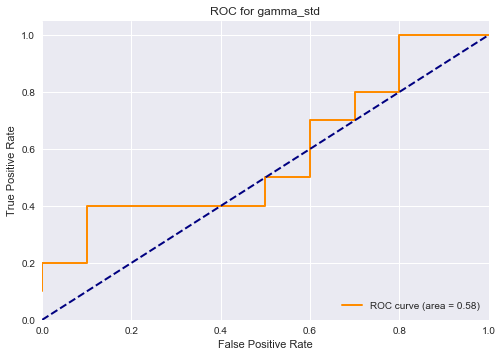

In [8]:
for label in (column_names_mean + column_names_std):
    graficar_roc(tabla,label, 'labels', 'S')


Logistic Regression

In [42]:
X = np.array(labels)
y = np.array(labels)
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)

X = tabla['delta_mean']
y = tabla['delta_mean']

lasso = linear_model.Lasso()
print(cross_val_score(lasso, X,y,groups=labels))  


/home/amascitti/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: Found input variables with inconsistent numbers of samples: [1, 13]

Support Vector Machine

In [43]:

X = np.array(labels)
y = np.array(labels)
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)



for train_index, test_index in sss.split(X, y):
    X_train = tabla.iloc[train_index, :-1]
    y = tabla.iloc[test_index, -1]
    clf = svm.SVC()
#    clf.fit(X_train, y)
    print("TRA:", train_index, "TEST:", test_index)
#    print("X_train: ", X_train)
    print("y: ", y)
    print(type(X_train))
    print(type(y))
#    print(clf.predict(tabla.iloc[test_index, :-1]))

TRA: [ 7 16 15  4 17 19 11  2  9  1 12 10 13  6  8  0 18  3] TEST: [ 5 14]
y:  5     P
14    S
Name: labels, dtype: object
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
TRA: [10 12  4  6 13 15  7 11 19  8 16  9  0 18  1  5 17  2] TEST: [ 3 14]
y:  3     P
14    S
Name: labels, dtype: object
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [15]:

X = np.array(labels)
y = np.array(labels)
sss = StratifiedShuffleSplit(n_splits=50, test_size=0.1, random_state=0)
sss.get_n_splits(X, y)

print(sss)       

for train_index, test_index in sss.split(X, y):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]



"""
diabetes = datasets.load_diabetes()
X = diabetes.data[:150]
y = diabetes.target[:150]
lasso = linear_model.Lasso()
print(cross_val_score(lasso, X, y))  
"""

StratifiedShuffleSplit(n_splits=50, random_state=0, test_size=0.1,
            train_size=None)
TRAIN: [ 7 16 15  4 17 19 11  2  9  1 12 10 13  6  8  0 18  3] TEST: [ 5 14]
TRAIN: [10 12  4  6 13 15  7 11 19  8 16  9  0 18  1  5 17  2] TEST: [ 3 14]
TRAIN: [ 5 13  8 14 19 10 11  1  4 17  2  6 12  0  7 18 16  3] TEST: [15  9]
TRAIN: [ 8 18  5  0  4  2 16 12  9  3 14 15 11 13  6 19 17  7] TEST: [10  1]
TRAIN: [ 0 17  4  6 15  3 14  5 19 18 11  9 10  2  1 16 12  7] TEST: [13  8]
TRAIN: [ 1  2 19  9 17  4  5 13 14 15 18  3 12 11  8  0 10  7] TEST: [16  6]
TRAIN: [ 1 18  0 10  9  4 19 13  2 11  5 17  6  3 14 16  7 12] TEST: [ 8 15]
TRAIN: [12  8  6 11 19 16 18  2 14 10 15  1 13  5  4  3  9  0] TEST: [17  7]
TRAIN: [ 4  3 13  2 19  5  0  7 10  9 17 16  6 14 11 18 15  1] TEST: [ 8 12]
TRAIN: [ 3  4 11 13  8  9  1 15 19 16  7  0 12 14 18 17  2  6] TEST: [10  5]
TRAIN: [ 1 17 11  0  6  9  8 10 18  7  3 19 15 12 16 14  2  5] TEST: [13  4]
TRAIN: [14 12  4  8  0  3 19  9 15 10 17  1 18  6  5 11 1

'\ndiabetes = datasets.load_diabetes()\nX = diabetes.data[:150]\ny = diabetes.target[:150]\nlasso = linear_model.Lasso()\nprint(cross_val_score(lasso, X, y))  \n'